In [2]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=365)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
twse_df_raw = pd.read_sql(query_twse, engine)

stock_df_raw = pd.read_sql(query_stock, engine)

sub_category_list = pd.read_sql(query_sub_category, engine)



In [4]:
import collections
df_rs70_category_week = pd.DataFrame()  #多筆每日強勢細產業

sub_category_list.rename(columns={'stock_id': '證券代號'}, inplace=True)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
data_date_list = collections.Counter(stock_df_raw['Date'].sort_values(ascending=False))

for day in data_date_list:
        day = day.strftime('%Y-%m-%d')
        # 取每天RS大於90的產業出來
        stock_df_today = stock_df_raw[stock_df_raw['Date']==day].copy()  
        stock_df_today.sort_values(by=['60RS_rank'], inplace=True)

        stock_df_today90 = stock_df_today[stock_df_today['60RS_rank']>90]

        merged_rs_sub = pd.merge(stock_df_today90, sub_category_list, on='證券代號', how='inner')  #RS超過90的
        merged_sub = pd.merge(stock_df_today, sub_category_list, on='證券代號', how='inner')  # 全部股票

        cols = ['Date', '證券代號', 'stock_name','60RS_rank','main_category','sub_category']
        merged_rs_sub = merged_rs_sub[cols]
        merged_sub = merged_sub[cols]

        #找細產業別 跟 母體
        df_rs70_sub_category = collections.Counter(merged_rs_sub['sub_category'])
        df_all_sub_category = collections.Counter(merged_sub['sub_category'])

        df_sub_category = pd.DataFrame()
        for i in df_rs70_sub_category:
                sub_category = {
                "date": [day],
                "sub_category": [i],
                "main_rank": [df_rs70_sub_category[i]],
                "all": [df_all_sub_category[i]],
                "pen": [round((df_rs70_sub_category[i]/df_all_sub_category[i])*100,2)]}

                df_sub_category_temp = pd.DataFrame(sub_category)
                df_sub_category = pd.concat([df_sub_category,df_sub_category_temp])
                df_sub_category.sort_values(by=['pen'], ascending=False, inplace=True)

        df_rs70_category_week = pd.concat([df_rs70_category_week,df_sub_category])

                


In [5]:
compare_df = pd.DataFrame()
countdown = 60  #看輪動天數
pen = 40

for day in data_date_list:
        day_change = day.strftime('%Y-%m-%d')
        countdown -= 1 
        df_rs = pd.DataFrame()
        if(countdown>0):   
                getIndex = list(data_date_list).index(day) # 取index 找下一天
                day_before = list(data_date_list)[getIndex+1].strftime('%Y-%m-%d')
                df_rs70_category_1 = df_rs70_category_week[(df_rs70_category_week['date'] == day_change) &(df_rs70_category_week['main_rank'] > 2) & (df_rs70_category_week['pen'] > pen)]
                df_rs70_category_2 = df_rs70_category_week[(df_rs70_category_week['date'] == day_before) &(df_rs70_category_week['main_rank'] > 2) & (df_rs70_category_week['pen'] > pen)]

                sub_category_list_now = list(df_rs70_category_1['sub_category'])
                sub_category_before = list(df_rs70_category_2['sub_category'])
                compare_add = [x for x in sub_category_list_now if x not in sub_category_before] #新進入名單
                compare_remove = [x for x in sub_category_before if x not in sub_category_list_now] #新進入名單
                compare_list = {
                "Date": [day_change],
                "add": [compare_add],
                "remove": [compare_remove],
                "add_count": [len(compare_add)],
                "remove_count": [len(compare_remove)],
                "diff_count": [len(compare_add) - len(compare_remove)]}

                compare_list_temp = pd.DataFrame(compare_list)
                compare_df = pd.concat([compare_df,compare_list_temp])

In [6]:
compare_df30 = compare_df.iloc[:60]
compare_df30['Date'] = pd.to_datetime(compare_df30['Date'])
twse_index = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數'].copy()
twse_index['Date'] = pd.to_datetime(twse_index['Date'])
merged_hist = pd.merge(compare_df30, twse_index, on='Date', how='inner')  # 全部股票

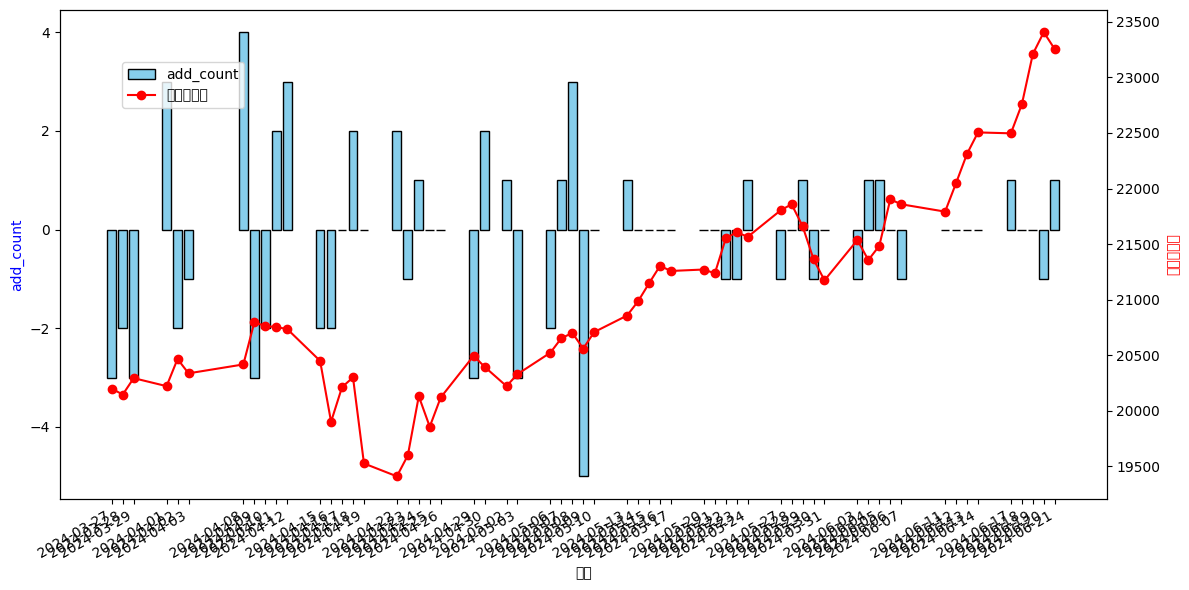

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# 禁用特定类型的警告
#warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')
warnings.filterwarnings("ignore", category=UserWarning)

# 假设 compare_df30 和 merged_hist 的数据如下
compare_df30_data = {
    'date': merged_hist['Date'],
    'diff_count': merged_hist['diff_count']
}

merged_hist_data = {
    'date': merged_hist['Date'],
    '價格指數值': merged_hist['價格指數值']
}

compare_df30_df = pd.DataFrame(compare_df30_data)
merged_hist_df = pd.DataFrame(merged_hist_data)

# 确保日期列为 datetime 类型
compare_df30_df['date'] = pd.to_datetime(compare_df30_df['date'])
merged_hist_df['date'] = pd.to_datetime(merged_hist_df['date'])

# 创建图表
fig, ax1 = plt.subplots(figsize=(12, 6))

# 绘制 compare_df30 的条形图
ax1.bar(compare_df30_df['date'], compare_df30_df['diff_count'], color='skyblue', edgecolor='black', label='add_count')

# 设置第一个 y 轴的标签
ax1.set_ylabel('add_count', color='blue')
ax1.set_xlabel('日期')



# 設置x軸刻度為實際存在的日期
ax1.set_xticks(compare_df30_df['date'])

# 格式化 x 轴为日期格式
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

# 自动旋转日期标签以避免重叠
fig.autofmt_xdate()

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制 merged_hist 的折线图
ax2.plot(merged_hist_df['date'], merged_hist_df['價格指數值'], color='red', marker='o', linestyle='-', label='價格指數值')
ax2.set_xticks(merged_hist_df['date'])

# 设置第二个 y 轴的标签
ax2.set_ylabel('價格指數值', color='red')

# 添加图例
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# 自动调整布局以适应标签
fig.tight_layout()

# 显示图表
plt.show()


In [8]:
#compare_df
# 看個別細產業
temp = sub_category_list[sub_category_list['sub_category'] == '記憶體']
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
temp2 = stock_df_raw[stock_df_raw['Date']=='2024-06-13']
temp3 = pd.merge(temp, temp2, on='證券代號', how='inner')  # 全部股票

cols = ['證券代號', 'stock_name', 'sub_category','20RS_rank','Date']
temp3 = temp3[cols]
temp3.sort_values(by=['20RS_rank'], inplace=True)
temp3



,證券代號,stock_name,sub_category,20RS_rank,Date
12,6276,安鈦克,記憶體,21.842818,2024-06-13
14,8084,巨虹,記憶體,24.390244,2024-06-13
16,8088,品安,記憶體,35.663957,2024-06-13
15,8088,品安,記憶體,35.663957,2024-06-13
0,2344,華邦電,記憶體,37.018970,2024-06-13
1,2344,華邦電,記憶體,37.018970,2024-06-13
13,6470,宇智,記憶體,44.878049,2024-06-13
11,5386,青雲,記憶體,46.883469,2024-06-13
18,8271,宇瞻,記憶體,70.460705,2024-06-13
5,3260,威剛,記憶體,72.845528,2024-06-13


In [10]:
tt = stock_df_raw[stock_df_raw['證券名稱'] == '信驊']
#tt.tail(50)

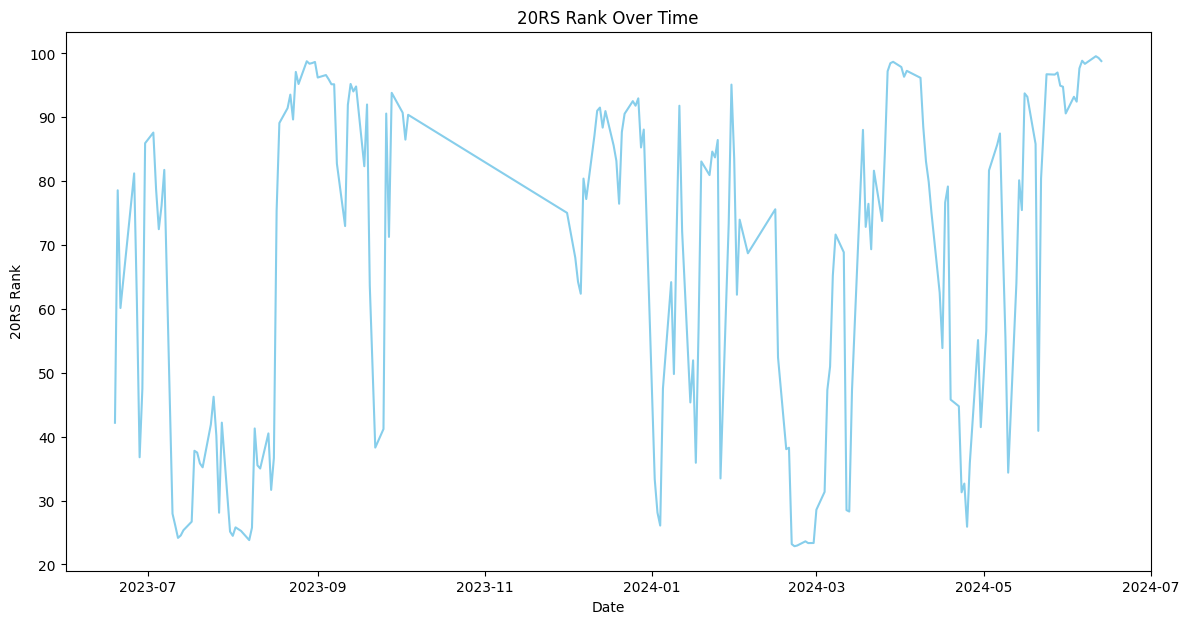

In [9]:
tt = stock_df_raw[stock_df_raw['證券名稱'] == '信驊']
import pandas as pd
import matplotlib.pyplot as plt


# 示例数据
data = {
    'date': tt['Date'],
    '60RS_rank': tt['60RS_rank']
}
tt_df = pd.DataFrame(data)

# 确保日期列是日期类型
tt_df['date'] = pd.to_datetime(tt_df['date'])

# 创建图表
plt.figure(figsize=(14, 7))
plt.plot(tt_df['date'], tt_df['60RS_rank'], color='skyblue')

# 设置标题和标签
plt.title('60RS Rank Over Time')
plt.xlabel('Date')
plt.ylabel('60RS Rank')

# 显示图表
plt.show()

# 可能需要60RS_RANK